In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("./space/pulsar_stars.csv")

In [4]:
df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [5]:
df["target_class"].value_counts()

0    16259
1     1639
Name: target_class, dtype: int64

In [6]:
X = df.drop(["target_class"], axis=1).values
X.shape

(17898, 8)

In [7]:
y = df["target_class"]
y.shape

(17898,)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
X_train_std.shape, X_test_std.shape

((12528, 8), (5370, 8))

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, plot_precision_recall_curve

log = LogisticRegression().fit(X_train_std, y_train)
y_pred = log.predict(X_test_std)
print("\nClassification Report\n\n", classification_report(y_test, y_pred))
print("Accuracy: %s" % accuracy_score(y_test, y_pred))
print("Balanced Accuracy: %s" % balanced_accuracy_score(y_test, y_pred))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
plot_precision_recall_curve(log, X_test_std, y_test, ax=ax);
plt.tight_layout()
fig.savefig("images/LR-Pulsar-PRCurve.png")


Classification Report

               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4878
           1       0.94      0.82      0.87       492

    accuracy                           0.98      5370
   macro avg       0.96      0.91      0.93      5370
weighted avg       0.98      0.98      0.98      5370

Accuracy: 0.9782122905027933
Balanced Accuracy: 0.9066828168281682


In [10]:
from algorithms import SimpleESClassifier
from algorithms import GeneticESClassifier
from algorithms import NaturalESClassifier
from algorithms import DifferentialEvolutionClassifier

from sklearn.metrics import plot_precision_recall_curve

def score(objective, iterations=100, text=""):
    ses = SimpleESClassifier(objective=objective, n_iter=iterations, random_state=0)
    ges = GeneticESClassifier(objective=objective, n_iter=iterations, random_state=0)
    nes = NaturalESClassifier(objective=objective, n_iter=iterations, random_state=0)
    dev = DifferentialEvolutionClassifier(objective=objective, n_iter=iterations * 10, random_state=0, bounds=(-20, 20))

    ses.fit(X_train_std, y_train)
    ges.fit(X_train_std, y_train)
    nes.fit(X_train_std, y_train)
    dev.fit(X_train_std, y_train)

    fig, axes = plt.subplots(2, 2, figsize=(8, 6), subplot_kw={"xlabel": "Iteration", "ylabel": "Accuracy"})
    axes[0][0].set_title("SimpleESClassifier Score")
    axes[0][0].plot(range(iterations), ses.history_)
    axes[0][1].set_title("GeneticESClassifier Score")
    axes[0][1].plot(range(iterations), ges.history_)
    axes[1][0].set_title("NaturalESClassifier Score")
    axes[1][0].plot(range(iterations), nes.history_)
    axes[1][1].set_title("DifferentialEvolutionClassifier Score")
    axes[1][1].plot(range(iterations * 10), dev.history_)
    plt.tight_layout()
    plt.savefig("images/" + text + "-AccCurve.png")
    plt.show()

    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    plot_precision_recall_curve(ses, X_test_std, y_test, ax=axes[0][0])
    plot_precision_recall_curve(ges, X_test_std, y_test, ax=axes[0][1])
    plot_precision_recall_curve(nes, X_test_std, y_test, ax=axes[1][0])
    plot_precision_recall_curve(dev, X_test_std, y_test, ax=axes[1][1])
    plt.tight_layout()
    plt.savefig("images/" + text + "-PRCurve.png")
    plt.show()

    print("\nSimpleESClassifier Report")
    y_pred = ses.predict(X_test_std)
    print(classification_report(y_test, y_pred))
    print("Accuracy: %s" % accuracy_score(y_test, y_pred))
    print("Balanced Accuracy: %s" % balanced_accuracy_score(y_test, y_pred))
    print("\nGeneticESClassifier Report")
    y_pred = ges.predict(X_test_std)
    print(classification_report(y_pred, y_test))
    print("Accuracy: %s" % accuracy_score(y_test, y_pred))
    print("Balanced Accuracy: %s" % balanced_accuracy_score(y_test, y_pred))
    print("\nNaturalESClassifier Report")
    y_pred = nes.predict(X_test_std)
    print(classification_report(y_pred, y_test))
    print("Accuracy: %s" % accuracy_score(y_test, y_pred))
    print("Balanced Accuracy: %s" % balanced_accuracy_score(y_test, y_pred))
    print("\nDifferentialEvolutionClassifier Report")
    y_pred = dev.predict(X_test_std)
    print(classification_report(y_pred, y_test))
    print("Accuracy: %s" % accuracy_score(y_test, y_pred))
    print("Balanced Accuracy: %s" % balanced_accuracy_score(y_test, y_pred))

100%|██████████| 1000/1000 [00:20<00:00, 48.60it/s]


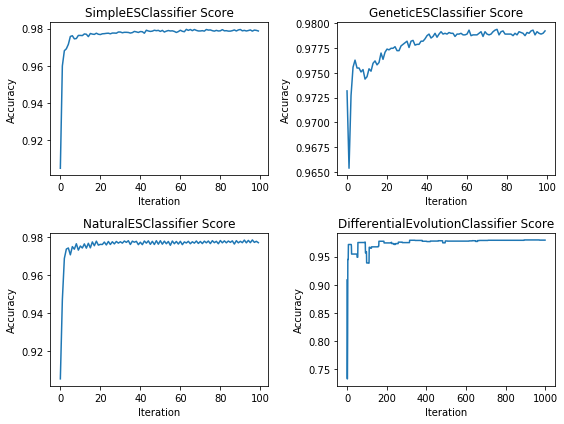

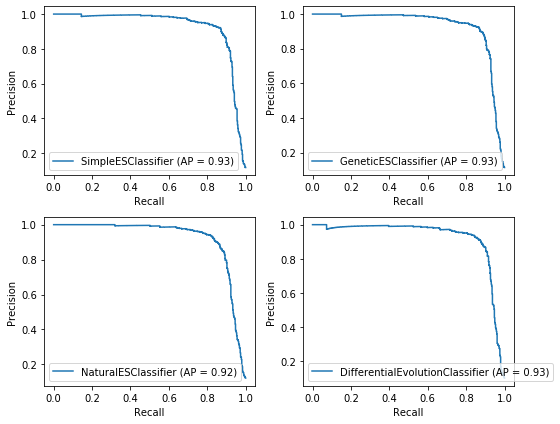


SimpleESClassifier Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4878
           1       0.94      0.83      0.88       492

    accuracy                           0.98      5370
   macro avg       0.96      0.91      0.93      5370
weighted avg       0.98      0.98      0.98      5370

Accuracy: 0.9791433891992551
Balanced Accuracy: 0.910850358503585

GeneticESClassifier Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4931
           1       0.83      0.93      0.88       439

    accuracy                           0.98      5370
   macro avg       0.91      0.96      0.93      5370
weighted avg       0.98      0.98      0.98      5370

Accuracy: 0.9793296089385475
Balanced Accuracy: 0.9136941369413694

NaturalESClassifier Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4962
           1       0.

In [11]:
from objectives import CrossEntropyObjective

score(CrossEntropyObjective(), text="Pulsar")

In [12]:
def plot_model(model, iterations, X, y, text):
    name = type(model).__name__

    y_pred = model.predict(X)
    print(name)
    print("Accuracy:          %s" % accuracy_score(y_test, y_pred))
    print("Balanced Accuracy: %s" % balanced_accuracy_score(y_test, y_pred))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    axes[0].set_title(name + " Score")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Score")
    axes[0].plot(range(iterations), model.history_)
    axes[1].set_title("PR Curve")
    plot_precision_recall_curve(model, X, y, ax=axes[1]);
    plt.tight_layout()
    plt.savefig("images/" + name + "-" + text + "-PRCurve.png")

Let's try tweaking the NaturalES hyperparameters.

In [13]:
ges = GeneticESClassifier(objective=CrossEntropyObjective(), n_iter=250, random_state=0, n_pop=75, p_elite=0.15, sigma=0.1)
ges.fit(X_train_std, y_train);

100%|██████████| 250/250 [00:31<00:00,  8.05it/s]


GeneticESClassifier
Accuracy:          0.9795158286778398
Balanced Accuracy: 0.9137966379663797


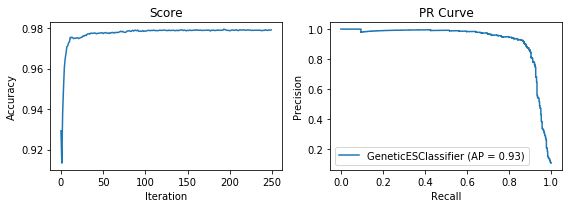

In [14]:
plot_model(ges, 250, X_test_std, y_test, "Pulsar")

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

ges = GeneticESClassifier(objective=CrossEntropyObjective(), n_iter=250, random_state=0, n_pop=75, p_elite=0.15, sigma=0.1)
ges = make_pipeline(StandardScaler(), ges)
ges_score = cross_val_score(ges, X, y)

log = make_pipeline(StandardScaler(), LogisticRegression())
log_score = cross_val_score(log, X, y)

100%|██████████| 250/250 [00:34<00:00,  7.32it/s]


In [16]:
print("GeneticESClassifier Accuracy: %0.5f (+/- %0.5f)" % (ges_score.mean(), ges_score.std() * 2))
print("LogisticRegression Accuracy:  %0.5f (+/- %0.5f)" % (log_score.mean(), log_score.std() * 2))

GeneticESClassifier Accuracy: 0.97860 (+/- 0.00431)
LogisticRegression Accuracy:  0.97810 (+/- 0.00488)


That went pretty well, so we'll look at another classification dataset.

In [17]:
df = pd.read_csv("./space/nasa.csv")

In [18]:
df.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [19]:
df["Hazardous"].value_counts()

False    3932
True      755
Name: Hazardous, dtype: int64

In [20]:
X = df[["Absolute Magnitude",
"Est Dia in Feet(min)",
"Est Dia in Feet(max)",
"Epoch Date Close Approach",
"Relative Velocity km per hr",
"Miles per hour",
"Miss Dist.(miles)",
"Orbit Uncertainity",
"Minimum Orbit Intersection",
"Jupiter Tisserand Invariant",
"Epoch Osculation",
"Eccentricity",
"Semi Major Axis",
"Inclination",
"Asc Node Longitude",
"Orbital Period",
"Perihelion Distance",
"Perihelion Arg",
"Aphelion Dist",
"Perihelion Time",
"Mean Anomaly",
"Mean Motion"]].values
X.shape

(4687, 22)

In [21]:
y = df["Hazardous"]
y.shape

(4687,)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y, test_size=0.3, )
X_train.shape, X_test.shape

((3280, 22), (1407, 22))

In [23]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
X_train_std.shape, X_test_std.shape

((3280, 22), (1407, 22))

In [24]:
log = LogisticRegression().fit(X_train_std, y_train)
y_pred = log.predict(X_test_std)
print("\nClassification Report\n\n", classification_report(y_test, y_pred))
print("Accuracy: %s" % accuracy_score(y_test, y_pred))
print("Balanced Accuracy: %s" % balanced_accuracy_score(y_test, y_pred))


Classification Report

               precision    recall  f1-score   support

       False       0.97      0.98      0.98      1180
        True       0.89      0.85      0.87       227

    accuracy                           0.96      1407
   macro avg       0.93      0.91      0.92      1407
weighted avg       0.96      0.96      0.96      1407

Accuracy: 0.9580668088130775
Balanced Accuracy: 0.9127379974613604


100%|██████████| 2500/2500 [00:25<00:00, 99.25it/s]


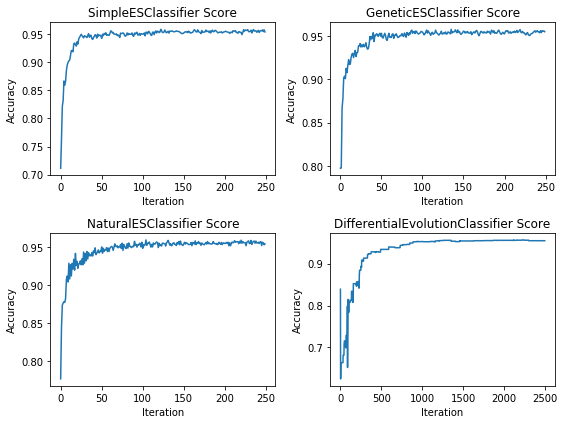

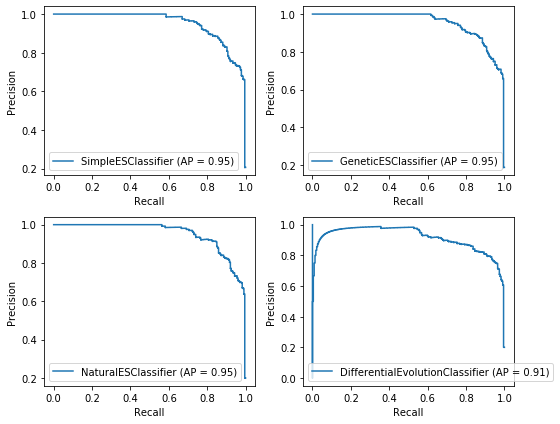


SimpleESClassifier Report
              precision    recall  f1-score   support

       False       0.97      0.98      0.98      1180
        True       0.89      0.85      0.87       227

    accuracy                           0.96      1407
   macro avg       0.93      0.92      0.92      1407
weighted avg       0.96      0.96      0.96      1407

Accuracy: 0.9587775408670931
Balanced Accuracy: 0.9167195549914133

GeneticESClassifier Report
              precision    recall  f1-score   support

       False       0.98      0.97      0.98      1184
        True       0.87      0.88      0.88       223

    accuracy                           0.96      1407
   macro avg       0.92      0.93      0.93      1407
weighted avg       0.96      0.96      0.96      1407

Accuracy: 0.9601990049751243
Balanced Accuracy: 0.9229037556932727

NaturalESClassifier Report
              precision    recall  f1-score   support

       False       0.98      0.97      0.98      1185
        True       0

In [25]:
score(CrossEntropyObjective(), iterations=250, text="Hazard")

Those DE graphs look pretty strange. We'll experiment with the NaturalES hyperparameters, then do the same with DE.

In [26]:
nes = NaturalESClassifier(objective=CrossEntropyObjective(), n_iter=2500, random_state=0, alpha=0.004)
nes.fit(X_train_std, y_train);

100%|██████████| 2500/2500 [01:55<00:00, 21.55it/s]


NaturalESClassifier
Accuracy:          0.9559346126510305
Balanced Accuracy: 0.9096878966624355


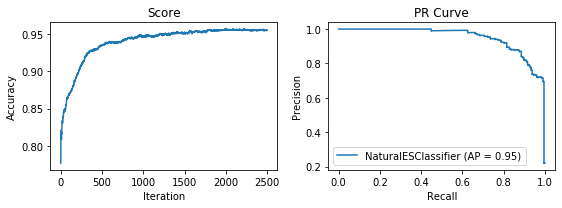

In [27]:
plot_model(nes, 2500, X_test_std, y_test, "Hazard")

In [28]:
dev = DifferentialEvolutionClassifier(objective=CrossEntropyObjective(), n_iter=750, random_state=None, n_pop=200, bounds=(-10, 10), F=0.1)
dev.fit(X_train_std, y_train);

100%|██████████| 750/750 [02:21<00:00,  5.28it/s]


DifferentialEvolutionClassifier
Accuracy:          0.9474058280028429
Balanced Accuracy: 0.9028242365414769


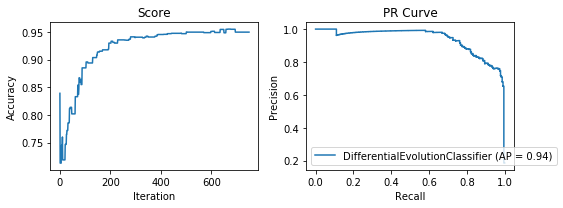

In [29]:
plot_model(dev, 750, X_test_std, y_test, "Hazard")

In [30]:
nes = NaturalESClassifier(objective=CrossEntropyObjective(), n_iter=2500, random_state=0, alpha=0.004)
nes = make_pipeline(StandardScaler(), nes)
nes_score = cross_val_score(nes, X, y)

dev = DifferentialEvolutionClassifier(objective=CrossEntropyObjective(), n_iter=750, random_state=None, n_pop=200, bounds=(-10, 10), F=0.1)
dev = make_pipeline(StandardScaler(), dev)
dev_score = cross_val_score(dev, X, y)

log = make_pipeline(StandardScaler(), LogisticRegression())
log_score = cross_val_score(log, X, y)

 14%|█▎        | 341/2500 [00:21<02:23, 15.00it/s]

KeyboardInterrupt: 

In [ ]:
print("NaturalESClassifier Accuracy:             %0.5f (+/- %0.5f)" % (nes_score.mean(), nes_score.std() * 2))
print("DifferentialEvolutionClassifier Accuracy: %0.5f (+/- %0.5f)" % (dev_score.mean(), dev_score.std() * 2))
print("LogisticRegression Accuracy:              %0.5f (+/- %0.5f)" % (log_score.mean(), log_score.std() * 2))